In [1]:
#Automated reloading of custom modules
%load_ext autoreload
%autoreload 2

#Standard modules
import os
import time
import random
import json

import numpy as np
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime

#Custom modules
import helpers as hlp
import models as mdl

#!nvidia-smi

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### GPU and Reproductability

In [2]:
# Check avaibale device
DEVICE = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(DEVICE))
torch.cuda.empty_cache()

# Reproductilility
SEED = 0
hlp.set_seed(SEED)



Device: cuda:7


### Parameters

In [10]:
#Dataset
DATASET = "CIFAR10" 
MODEL = "ResNet9"
REDUCED = 0.01
FEATURE_DIM = 100
FED_CLASSIFIER = False

#Collaborative learning
N_CLIENTS = 4
SIZES = None # None for uniform sizes or array of length N_CLIENTS using all the data
ALPHA = "uniform" #'uniform', 'disjoint' or postive.

#Learning
BATCH_SIZE = 32
ROUNDS = 100
EPOCHS_PER_ROUND = 1
LR=1e-3
LAMBDA_KD = 1
N_AVG = None
LAMBDA_DISC = 0
CRITERION = nn.CrossEntropyLoss()
CRITERION_KD = nn.MSELoss()
CRITERION_DISC = nn.BCELoss()
N_EVAL = 1 #Evaluate train and test performace after N_EVAL epochs

#Directories
time_string = time.strftime("%d%h%y_%H:%m:%S")
EXPORT_DIR = "./saves/Experiments/" + DATE.strftime("%d-%m-%Y/%H-%M-%S")
#os.makedirs(EXPORT_DIR, exist_ok=True)

### Data loading

** Using CIFAR **
Load train data...
Files already downloaded and verified
Load validation data...
Files already downloaded and verified
Dataset sizes:
	- Train: (500, 3, 32, 32) (6.148 MB)
	- Validation (100, 3, 32, 32) (1.2296 MB)


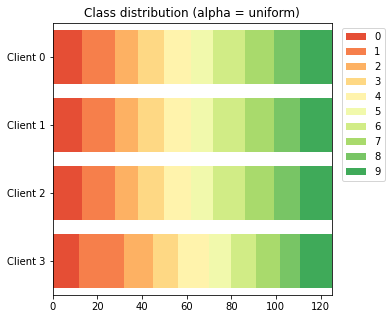

In [4]:
# Load data
train_input, train_target, val_input, val_target, meta = hlp.load_data(dataset=DATASET, reduced=REDUCED, device=DEVICE)

#Create custom torch datasets
train_ds = hlp.CustomDataset(train_input, train_target)
val_ds = hlp.CustomDataset(val_input, val_target)

#Split dataset
train_ds_list, val_ds_list = hlp.split_dataset(N_CLIENTS, train_ds, val_ds, ALPHA, SIZES)

#Create dataloader
train_dl_list = hlp.ds_to_dl(train_ds_list, batch_size=BATCH_SIZE)
val_dl_list = hlp.ds_to_dl(val_ds_list, batch_size=10*BATCH_SIZE)
global_val_dl = hlp.ds_to_dl(val_ds, batch_size=10*BATCH_SIZE)
global_train_dl = hlp.ds_to_dl(train_ds, batch_size=10*BATCH_SIZE)

#Visualize partition
hlp.visualize_class_dist(train_ds_list, meta["n_class"], title="Class distribution (alpha = {})".format(ALPHA),savepath=None)

# Store dataset sizes
meta["n_total"] = train_input.shape[0] 
meta["n_local"] = [ds.inputs.shape[0] for ds in train_ds_list]

## Traditional (spearated) learning

Round 100 done. (0.6s)          

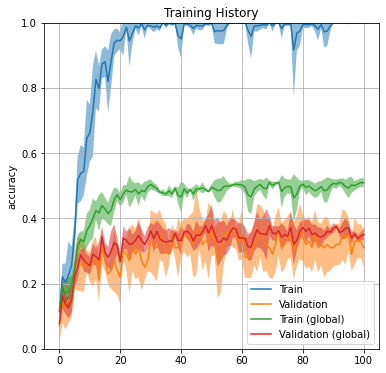

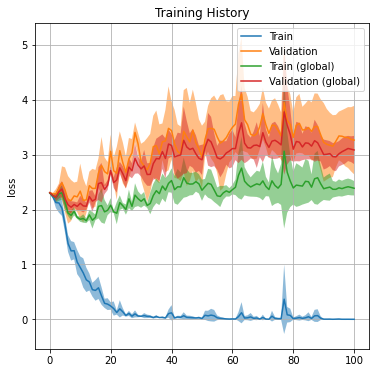

In [5]:
# Model initialization
client_models = [mdl.get_model(MODEL, FEATURE_DIM, meta).to(DEVICE) for _ in range(N_CLIENTS)]

# Performance tracker
perf_trackers = [hlp.PerfTracker(client_models[i], 
                                 {"Train": train_dl_list[i], "Validation": val_dl_list[i], "Train (global)": global_train_dl, "Validation (global)": global_val_dl}, 
                                 CRITERION, meta["n_class"], ID="Client {}".format(i)) for i in range(N_CLIENTS)]

# Optimizers
optimizers = [torch.optim.Adam(m.parameters(), lr=LR) for m in client_models]

# Feature tracker
feat_tracker = hlp.FeatureTracker(client_models, train_dl_list, FEATURE_DIM, meta)

#Each client updates its model independently on its own dataset
for r in range(ROUNDS):
    t0 = time.time()
    for client_id in range(N_CLIENTS):
        #Setting up the local training
        model = client_models[client_id]
        model.train()
        optimizer = optimizers[client_id]

        #Local update
        for e in range(EPOCHS_PER_ROUND):
            for inputs, target in train_dl_list[client_id]:
                optimizer.zero_grad()
                logits = model(inputs)
                loss = CRITERION(logits, target)
                loss.backward()
                optimizer.step()
        
        #Tracking performance
        if (r+1) % N_EVAL == 0 or (r+1) == ROUNDS:
            perf_trackers[client_id].new_eval(index=r+1)      
    
    # Compute representations
    feat_tracker.new_round()

    t1 = time.time()    
    print("\rRound {} done. ({:.1f}s)".format(r+1, t1-t0), end=10*" ") 
    

# Plot training history
hlp.plot_global_training_history(perf_trackers, metric="accuracy")
hlp.plot_global_training_history(perf_trackers, metric="loss")

### Learning with private KD

Round 100 done. (0.7s)          

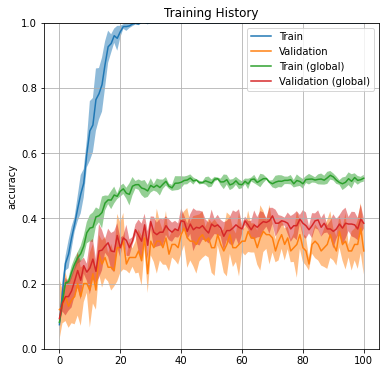

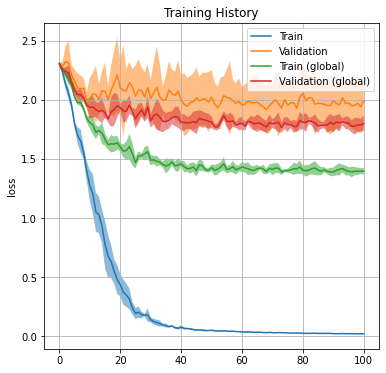

In [11]:
# Model initialization
client_models_kd = [mdl.get_model(MODEL, FEATURE_DIM, meta).to(DEVICE) for _ in range(N_CLIENTS)]

# Performance tracker
perf_trackers_kd = [hlp.PerfTracker(client_models_kd[i], {"Train": train_dl_list[i], "Validation": val_dl_list[i], "Train (global)": global_train_dl, "Validation (global)": global_val_dl}, 
                                    CRITERION, meta["n_class"], ID="Client {} (KD)".format(i)) for i in range(N_CLIENTS)]

# Optimizers
optimizers_kd = [torch.optim.Adam(m.parameters(), lr=LR) for m in client_models_kd]

# Feature tracker and discriminator
feat_tracker_kd = hlp.FeatureTracker(client_models_kd, train_dl_list, FEATURE_DIM, meta)
discriminators = [mdl.Discriminator("prob_product", client_models_kd[i].classifier) for i in range(N_CLIENTS)]

#Each client updates its model locally on its own dataset (Standard)
for r in range(ROUNDS):
    t0 = time.time()
    
    for client_id in range(N_CLIENTS):
        #Setting up the local training
        disc = discriminators[client_id]
        model = client_models_kd[client_id]
        model.train()
        optimizer = optimizers_kd[client_id]

        #Local update
        for e in range(EPOCHS_PER_ROUND):
            for inputs, targets in train_dl_list[client_id]:
                # Reset gradient
                optimizer.zero_grad()
                
                # Local representation
                features = model.features(inputs)
                logits = model.classifier(features)
                
                # Compute estimated probabilities
                features_global = feat_tracker_kd.get_global_features(f=FRACTION).to(DEVICE)
                targets_global = torch.arange(meta["n_class"]).to(DEVICE)
                scores, disc_targets = disc(features, features_global, targets, targets_global)
                
                # Optimization step
                loss = CRITERION(logits, targets) + LAMBDA_KD * CRITERION_KD(features, features_global[targets]) + LAMBDA_DISC * CRITERION_DISC(scores, disc_targets)
                loss.backward()
                optimizer.step()
        
        # Use FedAvg on the classifer
        if FED_CLASSIFIER:
            # Aggregation (weighted average)
            global_classifier = mdl.get_model(MODEL, FEATURE_DIM, meta).to(DEVICE)
            global_parameters = global_classifier.classifier.state_dict()
            for k in global_parameters.keys():
                global_parameters[k] = torch.stack([(meta["n_local"][i] / meta["n_total"]) * client_models_kd[i].classifier.state_dict()[k] for i in range(N_CLIENTS)], 0).sum(0)
            
            for model in client_models_kd:
                model.classifier.load_state_dict(global_parameters)
        
        #Tracking performance
        if (r+1) % N_EVAL == 0 or (r+1) == ROUNDS:
            perf_trackers_kd[client_id].new_eval(index=r+1)      
            
    # Compute representations
    feat_tracker_kd.new_round()
    
    t1 = time.time()    
    print("\rRound {} done. ({:.1f}s)".format(r+1, t1-t0), end=10*" ")  

# Plot training history
hlp.plot_global_training_history(perf_trackers_kd, metric="accuracy")
hlp.plot_global_training_history(perf_trackers_kd, metric="loss")

In [7]:
hlp.compare(perf_trackers_kd, perf_trackers)

Average accuracy improvement:
	Train: 0.000 (+- 0.000)
	Validation: 0.060 (+- 0.082)
	Train (global): 0.016 (+- 0.014)
	Validation (global): 0.057 (+- 0.034)


{'Train': array([0., 0., 0., 0.]),
 'Validation': array([ 0.  ,  0.12, -0.04,  0.16]),
 'Train (global)': array([ 0.02 ,  0.028, -0.008,  0.022]),
 'Validation (global)': array([0.01, 0.09, 0.04, 0.09])}

### Convert to executable

In [90]:
#Convert to executable (without the Magic cells)
#!jupyter nbconvert \
#    --TagRemovePreprocessor.enabled=True \
#    --TagRemovePreprocessor.remove_cell_tags 'Magic' \
#    --TemplateExporter.exclude_markdown=True \
#    --to python "PrivateKD.ipynb"

[NbConvertApp] Converting notebook PrivateKD.ipynb to python
[NbConvertApp] Writing 9152 bytes to PrivateKD.py


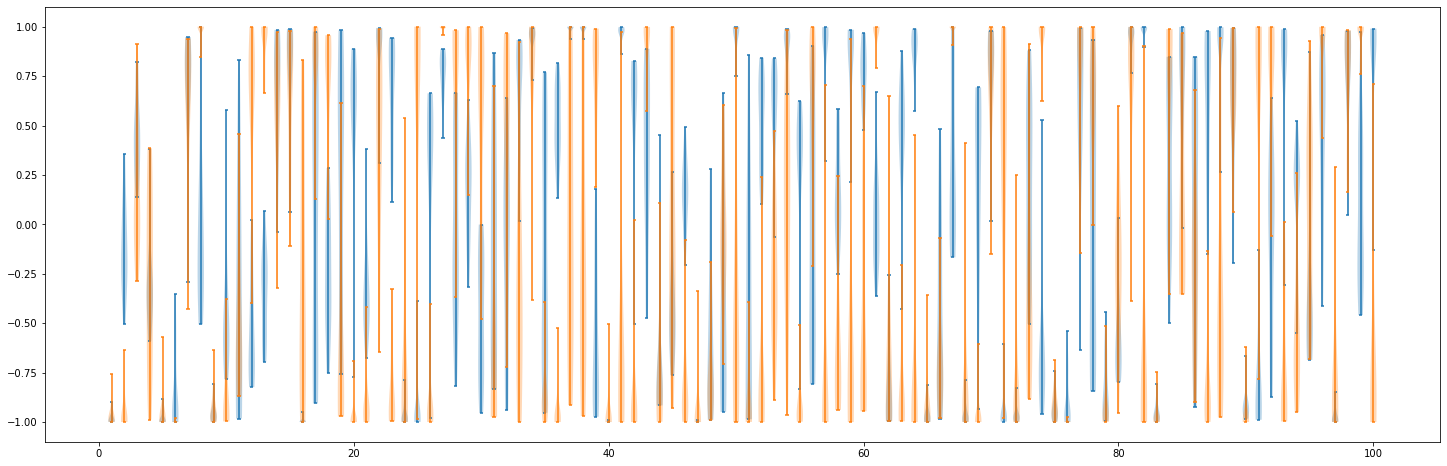

In [128]:
user = 0
r = -1
fig, ax = plt.subplots(1,1, figsize=(25,8))
with torch.no_grad():
    data = feat_tracker_kd.buffers_features[r][feat_tracker_kd.idx[user]]
    targets = feat_tracker_kd.buffers_targets[r][feat_tracker_kd.idx[user]]
    for c in [1,7]:
        plt.violinplot(data[targets == c].transpose(0,1))

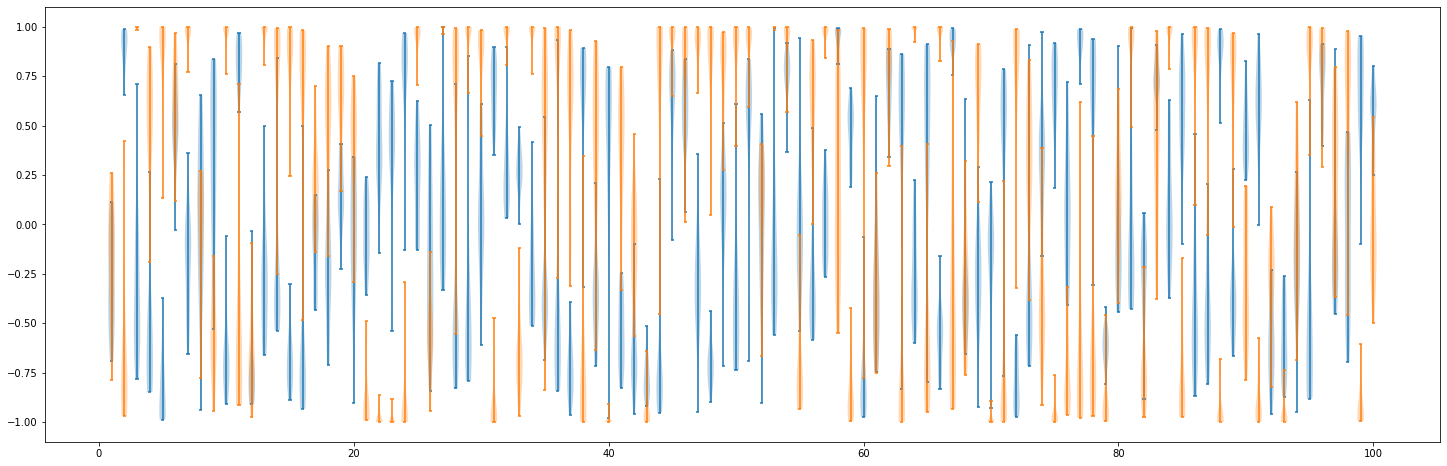

In [127]:
user = 0
r = -1
fig, ax = plt.subplots(1,1, figsize=(25,8))
with torch.no_grad():
    data = feat_tracker.buffers_features[r][feat_tracker.idx[user]]
    targets = feat_tracker.buffers_targets[r][feat_tracker.idx[user]]
    for c in [1,7]:
        plt.violinplot(data[targets == c].transpose(0,1))

In [124]:
m = client_models_kd[0]
f = feat_tracker_kd.get_global_features().to(DEVICE)
l = m.classifier(f)
p = F.softmax(l, dim=1).argmax(1)
p

tensor([0, 1, 2, 3, 4, 5, 2, 9, 8, 9], device='cuda:7')

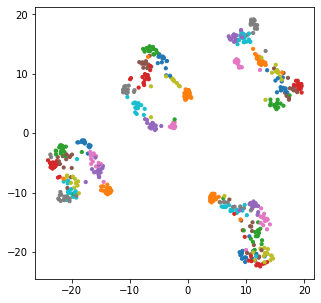

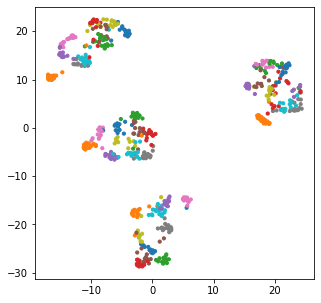

In [137]:
ft_val_kd = hlp.FeatureTracker(client_models_kd, val_dl_list, FEATURE_DIM, meta)
ft_val = hlp.FeatureTracker(client_models, val_dl_list, FEATURE_DIM, meta)

feat_tracker.plot_tSNE(50)
feat_tracker_kd.plot_tSNE(50)

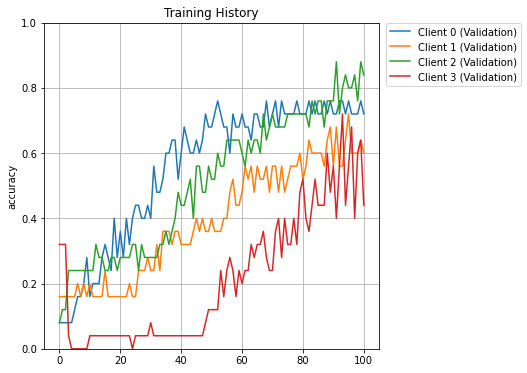

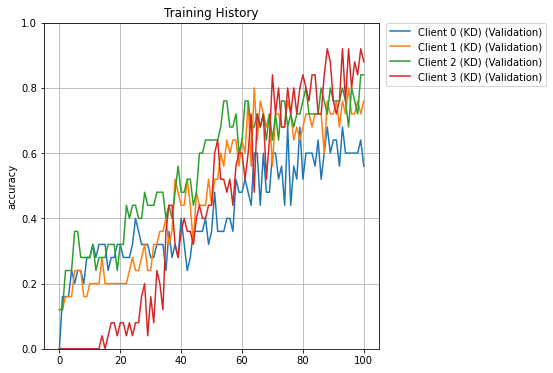

In [123]:
which = "Validation"
hlp.plot_global_training_history(perf_trackers, metric="accuracy", which=which, shaded=False)
hlp.plot_global_training_history(perf_trackers_kd, metric="accuracy", which=which, shaded=False)

In [11]:
y = json.dumps(meta, indent=4)
print(y)

TypeError: print() argument after ** must be a mapping, not str

In [17]:
import os
os.path.join("./test/", "subdir")

'./test/subdir'

In [19]:
def foo(a, b, c=1):
    print(a, b, c)

d = {"b": 3, "c": 10}

foo("string", **d)

string 3 10


In [13]:
import tmp
tmp.run_privateKD(2, "MNIST", "LeNet5", rounds=2)

(None, None)

In [24]:
del d["b"]
d

{'c': 10}

In [42]:
def foo(a):
    print(a)
    
s = "/save/"

foo(a = os.path.join(s, "test.png") if s is not None else None)

/save/test.png


In [49]:
t = False
for r in range(100):
    if (t and (r+1) % t == 0) or (r+1) == 100:
        print(r+1)

100
